In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

#
# Andrew Wetzel's gizmo analysis code + helpful utilities
#
# Here:      https://bitbucket.org/awetzel/gizmo_analysis
# and here:  https://bitbucket.org/awetzel/utilities
#
#
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

In [2]:
wdir = "/home/aemerick/work/gizmo_runs/metal_diff/m11q_res880"

#wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700"

In [82]:
#
# First, lets grab a snapshot
#
sim_index = 600

part = gizmo.io.Read.read_snapshots(['star','gas'], # types of particles to load. Gas and/or stars
                                    'index',        # what the next value describes (check docstring for more)
                                    sim_index,      # simulation output index (nth output)
                                    assign_host_principal_axes=True,    # yes! compute the disk of the galaxy
                                    simulation_directory = wdir)

#
# (and for the sake of this analysis, I'm also grabbing the 1st snapshot, aka the initial conditions)
#    no stars in this one, so just need to get gas
part0 = gizmo.io.Read.read_snapshots(['gas'], 'index', 0,
                                    # assign_host_principal_axes=True, don't need to do this for this one
                                    simulation_directory = wdir)


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 129840464 particles
    dark2     (id = 2): 8997544 particles
    gas       (id = 0): 128788874 particles
    star      (id = 4): 1058548 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.9

In [84]:
#
# This may not bethe same for all sims. But will be something like this:
#
#    load some information about the halo for this galaxy. This isn't strictly necessary, but
#    it is useful to know what the virial radius and mass are.
#
full_halo_data = np.genfromtxt(wdir + '/halo/snapshot_600.z0.000.AHF_halos',names=True)

# save some in a simple dict for z = 0 properties
#    first index of full halo data is the z=0 properties.
#    annoying integers in the names are the column numbers
#       Masses in (Msun), distances in kpc
halo_data = {'Mvir' :   full_halo_data['Mvir4'][0],
             'Rvir' :   full_halo_data['Rvir12'][0],
             'M_gas':   full_halo_data['M_gas45'][0],
             'M_star':  full_halo_data['M_star65'][0]}

for k in halo_data.keys():
    print (k,halo_data[k])
    
del(full_halo_data) # toss

Mvir 114537000000.0
Rvir 121.89
M_gas 4606950000.0
M_star 334462000.0


In [85]:
#
# For this analysis, I'm computing radial profiles. Define the ranges and bins
# 
r_min, r_max = 0.0, 1.0 # in units of R_vir
r_min = r_min * halo_data['Rvir'] # now in kpc
r_max = r_max * halo_data['Rvir']
nbins = 100
dr    = (r_max-r_min)/(float(nbins))

In [87]:
#
# Now, lets create radial profiles of the TOTAL metal mass
#
#   Use A. Wetzel's binning utilitis
#

fields = ['mass','mass.metals','mass.si','mass.o','mass.c','mass.fe']

# profiling utilitiy
SpeciesProfile = gizmo_ut.particle.SpeciesProfileClass(
                 scaling = 'linear', limits=[r_min,r_max], width=dr,
                 dimension_number=3)

profile = {}
norm_dict = {}
initial_dict = {}
for field in fields:
    profile[field] = SpeciesProfile.get_profiles(part, species=['gas','star'], property_name=field,
                                                    property_statistic='sum',
                                                    # property_select = select_dict,
                                                    weight_by_mass = False)
    
    # compute the initial amount of these fields
    initial_dict[field] = np.sum(part0['gas'].prop(field))
    
    #
    # compute the normalization (total amount produced by stars in the sim)
    # so we need to also subtract out the amount initially present
    norm_dict[field]    = np.sum(part['star'].prop(field)) + np.sum(part['gas'].prop(field)) -\
                          initial_dict[field]
    


# in utilities.particle.SpeciesProfile():
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%) are within limits = [0.000, 121.890]
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%) are within limits = [0.000, 121.890]
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%) are within limits = [0.000, 121.890]
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%) are within limits = [0.000, 121.890]
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%) are within limits = [0.000, 121.890]
  input 128788874 distances -  4420402 (3.4%) are within limits = [0.000, 121.890]
  input  1058548 distances -   759210 (71.7%

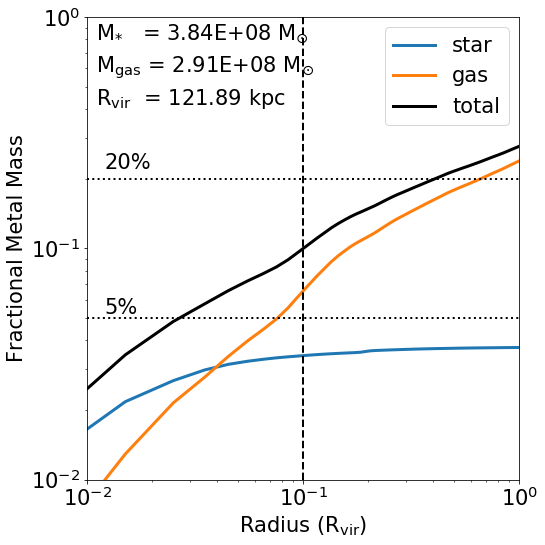

In [100]:
plot_settings()
fig,ax=plt.subplots()
fig.set_size_inches(8,8)
field = 'mass.fe'

normplot = np.cumsum( profile[field]['gas']['sum'] + profile[field]['star']['sum'] )

norm = norm_dict[field]

for ptype in ['star','gas']:
    ax.plot( profile[field][ptype]['distance']/halo_data['Rvir'],
             np.cumsum(profile[field][ptype]['sum']) / norm, label = ptype, lw = 3)
    
ax.plot( profile[field]['star']['distance']/halo_data['Rvir'],
             normplot/norm, label = 'total', color = 'black', lw = 3)
        
ax.set_ylim(0.01,1.0)
ax.set_xlim(0.01,1.0) 
#
#
#
ax.plot([0.1,0.1],ax.get_ylim(),color='black',lw=2,ls='--')

ax.plot(ax.get_xlim(),[0.05,0.05],color='black',lw=2,ls=':')
ax.plot(ax.get_xlim(),[0.20,0.20],color='black',lw=2,ls=':')
    
    
ax.legend(loc='best')

ax.semilogy()
ax.semilogx()

ax.set_ylabel(r'Fractional Metal Mass')
ax.set_xlabel(r"Radius (R$_{\rm vir}$)")


Mgas = np.sum(profile['mass']['gas']['sum'][profile['mass']['gas']['distance'] < 0.1*halo_data['Rvir']])
Mstar = np.sum(profile['mass']['star']['sum'][profile['mass']['star']['distance'] < 0.1*halo_data['Rvir']])

xy = (0.02,0.95)
ax.annotate(r'M$_{*}$   = %4.2E M$_{\odot}$'%(Mstar),xy,xy,xycoords='axes fraction')
xy = (0.02,0.88)
ax.annotate(r'M$_{\rm gas}$ = %4.2E M$_{\odot}$'%(Mgas),xy,xy,xycoords='axes fraction')
xy = (0.02,0.81)
ax.annotate(r'R$_{\rm vir}$  = %.2f kpc'%(halo_data['Rvir']),xy,xy,xycoords='axes fraction')


ax.annotate(r"20%", (0.012,0.22),(0.012,0.22))
ax.annotate(r"5%", (0.012,0.052),(0.012,0.052))

plt.tight_layout()

fig.savefig(wdir + '/m11q_res880_metaldiff.png')

In [56]:
np.sum(profile['mass']['gas']['sum'][profile['mass']['gas']['distance'] < 4]) / 1.0E8

1.000986

In [57]:
si_total = np.sum(part['gas'].prop('mass.si')) + np.sum(part['star'].prop('mass.si'))

si_yield = si_total / np.sum(part['star'].prop('mass'))

print(si_total)
print(si_yield)

1095638.2
0.0016617696
